In [39]:
#instalacja pakietu gdown
!pip install -U --no-cache-dir gdown --pre
#usuwanie i tworzenie pustego katalogu data
!rm -rf data && mkdir data

#pobieranie zip-a ze zdjęciami
!gdown --fuzzy https://drive.google.com/file/d/1xPTV0tMVDxZIxSVotjqLaLjbeCskM1L0/view?usp=sharing -O data.zip


#rozpakowywanie pliku data.zip do katalogu data
!unzip -q data.zip -d data


Downloading...
From: https://drive.google.com/uc?id=1xPTV0tMVDxZIxSVotjqLaLjbeCskM1L0
To: /content/data.zip
100% 903k/903k [00:00<00:00, 143MB/s]


In [40]:
import matplotlib.pyplot as plt
import numpy as np
import PIL
import tensorflow as tf
import glob

from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential

In [41]:
import shutil
import os

def duplicate_dataset(source_folder, destination_folder):
    """
    Kopiuje całą strukturę folderów z danymi
    """
    if not os.path.exists(destination_folder):
        # Kopiuje całą strukturę folderów
        shutil.copytree(source_folder, destination_folder)
        print(f"Skopiowano {source_folder} do {destination_folder}")
    else:
        print("Folder docelowy już istnieje!")


In [42]:
image_count = len(list(glob.glob('data/**/*.jpg')))
print(f'{image_count} examples of bins')

175 examples of bins


In [43]:
Bio_count = len(list(glob.glob('data/bio/*.jpg')))
Papier_count = len(list(glob.glob('data/papier/*.jpg')))
Plastik_count = len(list(glob.glob('data/plastik/*.jpg')))
Szkło_count = len(list(glob.glob('data/szkło/*.jpg')))
Zmieszane_count = len(list(glob.glob('data/zmieszane/*.jpg')))
print(f'{(Bio_count, Papier_count, Plastik_count,Szkło_count, Zmieszane_count)} examples of Bio, Paper, Plastic, Glass, mixed trash bins')

(35, 35, 35, 35, 35) examples of Bio, Paper, Plastic, Glass, mixed trash bins


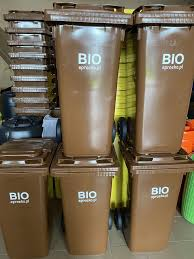

In [44]:
Bio = list(glob.glob('data/bio/*'))
PIL.Image.open(str(Bio[3]))

In [45]:

class_count = 5


In [46]:
import os
import shutil
import glob
import tensorflow as tf

def augment_dataset_by_copying(data_folder, multiplier=2):
    class_folders = [f for f in os.listdir(data_folder) if os.path.isdir(os.path.join(data_folder, f))]

    for class_folder in class_folders:
        folder_path = os.path.join(data_folder, class_folder)
        jpg_files = glob.glob(os.path.join(folder_path, '*.jpg'))

        for copy_num in range(1, multiplier):
            for jpg_file in jpg_files:
                file_name = os.path.basename(jpg_file)
                name, ext = os.path.splitext(file_name)
                new_file_name = f"{name}_copy{copy_num}{ext}"
                new_file_path = os.path.join(folder_path, new_file_name)

                if not os.path.exists(new_file_path):
                    shutil.copy(jpg_file, new_file_path)

        print(f"Folder {class_folder}: {len(jpg_files)} → {len(jpg_files) * multiplier} plików")

# Dodaj to do swojego kodu przed tworzeniem datasetu:
def prepare_training_with_duplicated_data(multiplier=2):
    # Podwój dane
    augment_dataset_by_copying('data', multiplier)

    # Teraz utwórz dataset (twój oryginalny kod)
    train_ds = tf.keras.utils.image_dataset_from_directory(
        'data',
        validation_split=0.2,
        subset='training',
        seed=123,
        image_size=(img_height, img_width),
        batch_size=batch_size
    )

    val_ds = tf.keras.utils.image_dataset_from_directory(
        'data',
        validation_split=0.2,
        subset='validation',
        seed=123,
        image_size=(img_height, img_width),
        batch_size=batch_size
    )

    return train_ds, val_ds

# train_ds, val_ds = prepare_training_with_duplicated_data(multiplier=2)


In [47]:
def create_dataset_with_size(data_dir, img_size, batch_size):
    """Tworzy dataset z określonym rozmiarem obrazu"""
    train_ds = tf.keras.utils.image_dataset_from_directory(
        data_dir,
        validation_split=0.2,
        subset='training',
        seed=123,
        image_size=(img_size, img_size),
        batch_size=batch_size
    )

    val_ds = tf.keras.utils.image_dataset_from_directory(
        data_dir,
        validation_split=0.2,
        subset='validation',
        seed=123,
        image_size=(img_size, img_size),
        batch_size=batch_size
    )
    class_names = train_ds.class_names
    return train_ds.cache().prefetch(tf.data.AUTOTUNE), val_ds.cache().prefetch(tf.data.AUTOTUNE), class_names

In [48]:
import tensorflow as tf
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras import layers

def get_model(type='custom', dropout_rate=0.0, duplicate = False, input_size =224, batch_size = 32):
    model = None

    img_height = input_size
    img_width = input_size
    batch_size = batch_size

    if type == 'resnet_transfer':
        base_model = tf.keras.applications.ResNet50(
                include_top=False,
                input_shape=(img_height, img_width, 3),
                classes=class_count,
            )

        # Definiujemy wejście
        inputs = layers.Input(shape=(img_height, img_width, 3))

        # BRAK NORMALIZACJI - surowe dane (0-255) bezpośrednio do modelu
        # x = layers.Rescaling(1./255)(inputs)  # ZAKOMENTOWANE

        # BRAK AUGMENTACJI - tylko podstawowy przepływ danych
        # x = layers.RandomFlip("horizontal")(inputs)
        # x = layers.RandomRotation(0.1)(x)

        # Bezpośrednie przekazanie surowych danych do base_model
        x = base_model(inputs)
        x = layers.GlobalAveragePooling2D()(x)

        # BRAK DROPOUT - tylko podstawowa architektura
        # if dropout_rate > 0.0:
        #     x = layers.Dropout(dropout_rate)(x)

        predictions = layers.Dense(class_count, activation='sigmoid')(x)
        model = Model(inputs=inputs, outputs=predictions)

    elif type == 'resnet':
        model = tf.keras.applications.ResNet50(
                weights=None,
                input_shape=(img_height, img_width, 3),
                classes=class_count,
            )

    elif type == 'custom':
        model = Sequential([
            layers.Rescaling(1./255, input_shape=(img_height, img_width, 3)),
            layers.Conv2D(16, 3, padding='same', activation='relu'),
            layers.MaxPooling2D(),
            layers.Conv2D(32, 3, padding='same', activation='relu'),
            layers.MaxPooling2D(),
            layers.Conv2D(64, 3, padding='same', activation='relu'),
            layers.MaxPooling2D(),
            layers.Flatten(),
            layers.Dense(128, activation='relu'),
            layers.Dense(class_count)
        ])

    return model


In [49]:
def get_model2(architecture='resnet50', input_size=224, class_count=5, dropout_rate=0.0):
    input_shape = (input_size, input_size, 3)
    base_model = None

    if architecture == 'resnet50':
        base_model = tf.keras.applications.ResNet50(include_top=False, input_shape=input_shape)
    elif architecture == 'resnet101':
        base_model = tf.keras.applications.ResNet101(include_top=False, input_shape=input_shape)
    elif architecture == 'vgg16':
        base_model = tf.keras.applications.VGG16(include_top=False, input_shape=input_shape)
    elif architecture == 'inceptionv3':
        base_model = tf.keras.applications.InceptionV3(include_top=False, input_shape=input_shape)
    elif architecture == 'mobilenet':
        base_model = tf.keras.applications.MobileNet(include_top=False, input_shape=input_shape)
    else:
        raise ValueError("Unknown architecture type")

    base_model.trainable = False

    inputs = layers.Input(shape=input_shape)
    x = tf.keras.applications.imagenet_utils.preprocess_input(inputs)
    x = base_model(x, training=False)
    x = layers.GlobalAveragePooling2D()(x)

    if dropout_rate > 0.0:
        x = layers.Dropout(dropout_rate)(x)

    outputs = layers.Dense(class_count, activation='softmax')(x)

    model = tf.keras.Model(inputs, outputs)
    return model


In [50]:
x = 96
y = 32
for y in [32, 64, 128]:
    model = get_model('resnet_transfer', dropout_rate=0.2, input_size=96, batch_size=y)
    model.compile(optimizer='adam',
                  loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
                  metrics=['accuracy'])
    model.summary()

Model: "functional_16"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_34 (InputLayer)     │ (None, 96, 96, 3)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ resnet50 (Functional)           │ (None, 3, 3, 2048)     │    23,587,712 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d_16     │ (None, 2048)           │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_16 (Dense)                │ (None, 5)              │        10,245 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 23,597,957 (90.02 MB)

 Trainable params: 23,544,837 (89.82 MB)

 Non-trainable params: 53,120 (207.50 KB)

Model: "functional_17"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_36 (InputLayer)     │ (None, 96, 96, 3)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ resnet50 (Functional)           │ (None, 3, 3, 2048)     │    23,587,712 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d_17     │ (None, 2048)           │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_17 (Dense)                │ (None, 5)              │        10,245 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 23,597,957 (90.02 MB)

 Trainable params: 23,544,837 (89.82 MB)

 Non-trainable params: 53,120 (207.50 KB)

Model: "functional_18"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_38 (InputLayer)     │ (None, 96, 96, 3)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ resnet50 (Functional)           │ (None, 3, 3, 2048)     │    23,587,712 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d_18     │ (None, 2048)           │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_18 (Dense)                │ (None, 5)              │        10,245 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 23,597,957 (90.02 MB)

 Trainable params: 23,544,837 (89.82 MB)

 Non-trainable params: 53,120 (207.50 KB)


=== TEST ARCHITEKTURY: MOBILENET ===
Found 175 files belonging to 5 classes.
Using 140 files for training.
Found 175 files belonging to 5 classes.
Using 35 files for validation.


<ipython-input-49-297005867>:14: UserWarning: `input_shape` is undefined or non-square, or `rows` is not in [128, 160, 192, 224]. Weights for input shape (224, 224) will be loaded as the default.
  base_model = tf.keras.applications.MobileNet(include_top=False, input_shape=input_shape)


17225924/17225924 ━━━━━━━━━━━━━━━━━━━━ 1s 0us/step
Epoch 1/20
5/5 ━━━━━━━━━━━━━━━━━━━━ 16s 2s/step - accuracy: 0.1685 - loss: 3.3953 - val_accuracy: 0.2571 - val_loss: 2.0964
Epoch 2/20
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - accuracy: 0.2616 - loss: 2.4520 - val_accuracy: 0.2571 - val_loss: 1.8945
Epoch 3/20
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - accuracy: 0.2823 - loss: 2.2891 - val_accuracy: 0.4000 - val_loss: 1.7944
Epoch 4/20
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - accuracy: 0.3656 - loss: 1.7615 - val_accuracy: 0.4571 - val_loss: 1.6425
Epoch 5/20
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - accuracy: 0.4281 - loss: 1.6934 - val_accuracy: 0.4857 - val_loss: 1.4092
Epoch 6/20
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - accuracy: 0.5760 - loss: 1.0411 - val_accuracy: 0.4857 - val_loss: 1.3199
Epoch 7/20
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - accuracy: 0.6062 - loss: 1.0413 - val_accuracy: 0.4571 - val_loss: 1.2452
Epoch 8/20
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - accuracy: 0.6906 - loss:

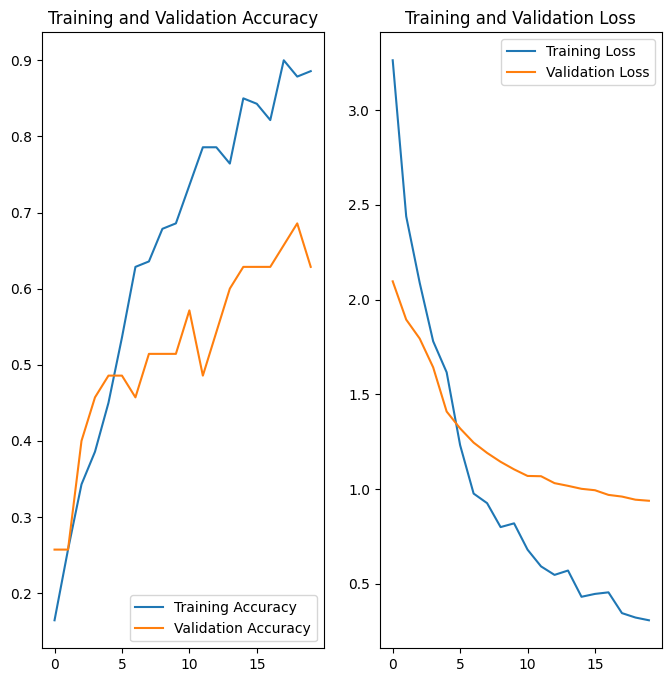

              precision    recall  f1-score   support

         bio       0.67      0.67      0.67         3
      papier       0.50      0.71      0.59         7
     plastik       0.67      0.44      0.53         9
       szkło       0.67      0.67      0.67         9
   zmieszane       0.71      0.71      0.71         7

    accuracy                           0.63        35
   macro avg       0.64      0.64      0.63        35
weighted avg       0.64      0.63      0.63        35

[[2 0 1 0 0]
 [0 5 0 1 1]
 [0 2 4 2 1]
 [0 2 1 6 0]
 [1 1 0 0 5]]


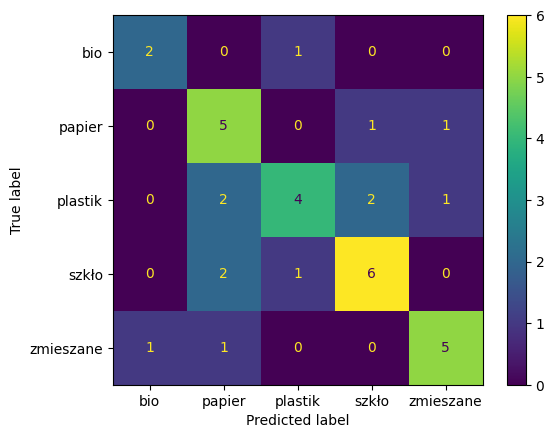

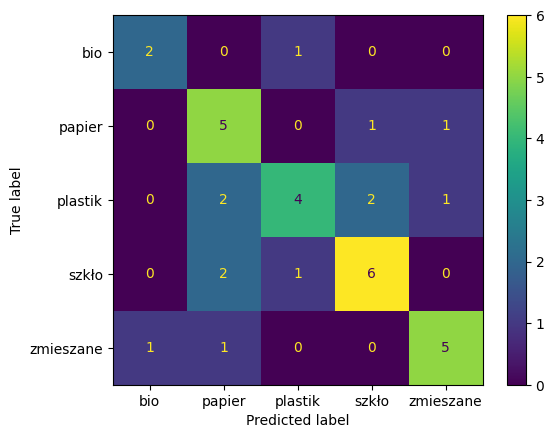

In [51]:
import time
import tensorflow as tf
epochs = 20
x = 96
y = 32
results = {}
architectures = ['resnet50', 'resnet101', 'vgg16', 'inceptionv3', 'mobilenetv']

for arch in architectures:
    print(f"\n=== TEST ARCHITEKTURY: {arch.upper()} ===")
    #print(f"\n=== TEST: Rozmiar obrazu {x}x{x} ===")
    train_ds, val_ds, class_names= create_dataset_with_size('data', 96, y)
    train_ds = train_ds.cache().shuffle(1000).prefetch(tf.data.AUTOTUNE)
    val_ds = val_ds.cache().prefetch(buffer_size=tf.data.AUTOTUNE)
    #model = get_model(arch, input_size=x, batch_size=y)
    #model.compile(optimizer='adam',
    #              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
    #              metrics=['accuracy'])
    model = get_model2(architecture=arch, input_size=x, class_count=5, dropout_rate=0.2)
    model.compile(optimizer='adam',
                  loss=tf.keras.losses.SparseCategoricalCrossentropy(),
                  metrics=['accuracy'])
    start_time = time.time()
    history = model.fit(
        train_ds,
        validation_data=val_ds,
        epochs=epochs
    )
    end_time = time.time()
    training_time = end_time - start_time
    print(f"Całkowity czas trenowania: {training_time:.2f} sekund")
    print(f"Średni czas na epokę: {training_time/epochs:.2f} sekund")


    acc = history.history['accuracy']
    val_acc = history.history['val_accuracy']

    loss = history.history['loss']
    val_loss = history.history['val_loss']

    epochs_range = range(epochs)

    plt.figure(figsize=(8, 8))
    plt.subplot(1, 2, 1)
    plt.plot(epochs_range, acc, label='Training Accuracy')
    plt.plot(epochs_range, val_acc, label='Validation Accuracy')
    plt.legend(loc='lower right')
    plt.title('Training and Validation Accuracy')

    plt.subplot(1, 2, 2)
    plt.plot(epochs_range, loss, label='Training Loss')
    plt.plot(epochs_range, val_loss, label='Validation Loss')
    plt.legend(loc='upper right')
    plt.title('Training and Validation Loss')
    plt.show()

    from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay

    def evaluate_model(val_ds, model, class_names):
      y_pred = []
      y_true = []

      for batch_images, batch_labels in val_ds:
          predictions = model.predict(batch_images, verbose=0)
          y_pred.extend(np.argmax(tf.nn.softmax(predictions), axis=1).tolist())
          y_true.extend(batch_labels.numpy().tolist())

      cm = confusion_matrix(y_true, y_pred)
      print(classification_report(y_true, y_pred, target_names=class_names))
      print(cm)

      disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=class_names)
      disp.plot()
      plt.show()

      return cm

    cm = evaluate_model(val_ds, model, class_names)

    import matplotlib.pyplot as plt

    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=class_names)
    disp.plot()
    plt.show()
